<a href="https://colab.research.google.com/github/benbatman/CNN_Projects/blob/main/inception_resnet_bloodcell_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# try:
#   %tensorflow_version 2.x 
# except Exception:
#   pass

import tensorflow as tf 
print(tf.__version__)

2.11.0


In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
# Import dependencies 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, \
Conv2D, BatchNormalization, ZeroPadding2D, MaxPooling2D, GlobalAveragePooling2D, \
Activation, add, Concatenate, Dropout, AveragePooling2D, Lambda
from tensorflow.keras.models import Model 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

from sklearn.metrics import confusion_matrix 
import numpy as np 
import matplotlib.pyplot as plt 

from glob import glob

In [3]:
# Resize the images 
IMAGE_SIZE = [224, 224]

# Some hyperparameters
EPOCHS=30
BATCH_SIZE = 32

In [4]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"benbatman","key":"4270bc28229aa46f69783a63cb12b8e2"}'}

In [5]:
!mkdir ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# Download dataset
!kaggle datasets download -d paultimothymooney/blood-cells

 92% 99.0M/108M [00:00<00:00, 162MB/s]
100% 108M/108M [00:00<00:00, 163MB/s] 


In [9]:
!unzip blood-cells.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_872.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8864.jpeg  
  inflating: dataset2-mast

In [10]:
train_dir = "/content/dataset2-master/dataset2-master/images/TRAIN"
test_dir =  "/content/dataset2-master/dataset2-master/images/TEST"

In [11]:
# number of files
train_files = glob(train_dir + '/*/*.jp*g')
test_files = glob(test_dir + '/*/*.jp*g')
train_files[:5], test_files[:5]

(['/content/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_31_84.jpeg',
  '/content/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_68_5146.jpeg',
  '/content/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_17_4576.jpeg',
  '/content/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_31_3517.jpeg',
  '/content/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_5_1803.jpeg'],
 ['/content/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_6_6152.jpeg',
  '/content/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_8_9981.jpeg',
  '/content/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_12_9486.jpeg',
  '/content/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_0_7764.jpeg',
  '/content/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_2_1728.jpeg'])

In [12]:
# Get number of classes 
folders = glob(train_dir + '/*')
print(f"Number of classes: {len(folders)}")

Number of classes: 4


In [13]:
np.random.choice(train_files)

'/content/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_24_6381.jpeg'

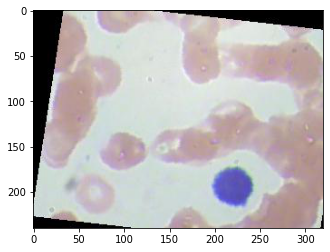

In [14]:
# look at images
plt.imshow(image.load_img(np.random.choice(train_files)))
plt.show()

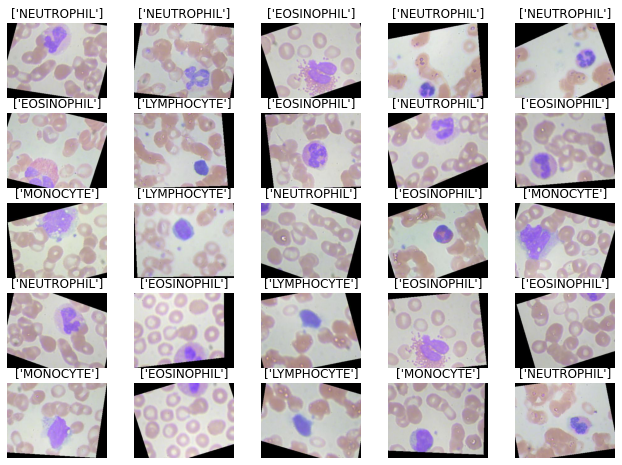

In [15]:
# Plot multiple random images
fig = plt.figure(figsize=(11,8))
r, c = 5,5
for i in range(1, r*c+1):
  image_path = np.random.choice(train_files)
  label = image_path.split("/")[-2]
  img = image.load_img(image_path)
  fig.add_subplot(r,c,i)
  plt.imshow(img)
  plt.title([label])
  plt.axis(False)

In [16]:
def identity_block(input_, kernel_size, filters):
  f1, f2, f3 = filters

  x = Conv2D(f1, (1,1),
             # kernel_initializer='he_normal
             )(input_)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f2, kernel_size, padding='same',
             # kernel_initializer='he_normal
              )(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f3, (1,1), 
             # kernel_initializer='he_normal'
             )(x)
  x = BatchNormalization()(x)

  x = add([x, input_]) # add original input in
  x = Activation('relu')(x)
  return x


In [17]:
def conv_block(input_,
               kernel_size, 
               filters,
               strides=(2,2)):
  
  f1, f2, f3 = filters

  x = Conv2D(f1, (1,1), strides=strides,
             # Kernel_initializer='he_normal',
             )(input_)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f2, kernel_size, padding='same',
             # Kernel_initializer='he_normal',
             )(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f3, (1,1),
             # Kernel_initializer='he_normal',
             )(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  shortcut = Conv2D(f3, (1,1), strides=strides,
                    # kernel_initializer='he_normal' 
                    )(input_)
  shortcut = BatchNormalization()(shortcut)

  x = add([x, shortcut])
  x = Activation('relu')(x)
  return x 



In [18]:
# Custom resnet 
i = Input(shape=IMAGE_SIZE + [3])
#print(i.shape)
x = ZeroPadding2D(padding=(3,3))(i)
#print(x.shape)
x = Conv2D(64, (7,7),
           strides=(2,2),
           padding='valid'
           )(x)
#print(x.shape)

x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1,1))(x)
#print(x.shape)
x = MaxPooling2D((3,3), strides=(2,2))(x)
#print(x.shape)

x = conv_block(x, 3, [64, 64, 256], strides=(1,1))
x = identity_block(x, 3, [64,64,256])
x = identity_block(x, 3, [64,64,256])


x = conv_block(x, 3, [128,128,512])
x = identity_block(x, 3, [128,128,512])
x = identity_block(x, 3, [128,128,512])
x = identity_block(x, 3, [128,128,512])

In [19]:
# top layers
x = GlobalAveragePooling2D()(x)
# x = GlobalMaxPoolng2D()(x) # could try this or flatten layer instead 
# x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(len(folders), activation='softmax')(x)

In [20]:
resnet_model = Model(inputs=i, outputs=outputs, name='resnet_model')

In [21]:
resnet_model.summary()

Model: "resnet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                       

In [22]:
resnet_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01), # The paper uses SGD
              metrics=['accuracy'])

## Inception-v4 Model

Replicating the paper below

https://arxiv.org/pdf/1602.07261.pdf

**Note:** Each Inception block is followed by filter-expansion layer
(1 × 1 convolution without activation) which is used for
scaling up the dimensionality of the filter bank before the
addition to match the depth of the input.

In [23]:
# Might not use, not created from paper
# No residuals, just a general inception architecture 
def inception_block(input_,
               kernel_size, 
               filters,
               strides=(1,1)):
  
  f1, f2_in, f2_out, f3_in, f3_out, f4_out = filters

  # 1x1 conv layer
  x0 = Conv2D(f1, (1,1), padding='same'
             # kernel_initializer='he_normal
             )(input_)
  x0 = BatchNormalization()(x0)
  x0 = Activation('relu')(x0)

  # 3x3 conv layer
  x1 = Conv2D(f2_in, (1,1), padding='same'
             # kernel_initializer='he_normal'
             )(input_)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)
  x1 = Conv2D(f2_out, (3,3), padding='same')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)

  # 5x5 conv layer
  # Could alternatively use two 3x3 conv layers
  x2 = Conv2D(f3_in, (1,1), padding='same'
             # kernel_initializer='he_normal'
             )(input_)
  x2 = Conv2D(f3_out, (5,5), padding='same')

  # x2 = Conv2D(f2_out, (3,3), padding='same')(x2)
  # x2 = BatchNormalization()(x2)
  # x2 = Activation('relu')(x2)
  # x2 = Conv2D(f2_out, (3,3), padding='same')(x2)
  # x2 = BatchNormalization()(x2)
  # x2 = Activation('relu')(x2)
  x2 = BatchNormalization()(x2)
  x2 = Activation('relu')(x2)


  # Max pooling layer 
  MaxPooling2D(pool_size=(3,3), strides=(1,1), 
                   padding='same')(input_)
  x3 = Conv2D(f4_out, (1,1), padding='same'
             # kernel_initializer='he_normal'
             )

  # Concatenation layer, along final axis
  concat = Concatenate([x0, x1, x2, x3], axis=-1)

  print(concat.shape)
  return concat

In [24]:
# Custom scaling layer to scale residuals as done in the paper 
class scaleLayer(tf.keras.layers.Layer):
  def __init__(self, scale_factor=0.2, **kwargs):
    super(scaleLayer, self).__init__()
    self.scale = tf.Variable(scale_factor)

  # Forward pass
  def call(self, inputs):
    scaled_inputs = inputs * self.scale
    assert inputs.shape == scaled_inputs.shape
    return scaled_inputs

In [97]:
# Define a conv2d function
def conv2d(input_,num_filters,kernel_size,strides=1,padding='same',activation=True, kernel_reg=None, name=None):

  if kernel_reg:
    x = Conv2D(num_filters, kernel_size, strides, padding=padding, kernel_regularizer=regularizers.l2(kernel_reg), data_format='channels_last', use_bias=False, name=name)(input_)
    x = BatchNormalization(axis=-1,scale=False,name=name)(x)
  else:
    x = Conv2D(num_filters, kernel_size, strides, padding=padding, data_format='channels_last', use_bias=False, name=name)(input_)
    x = BatchNormalization(axis=-1,scale=False,name=name)(x)
  if activation:
    x = Activation('relu',name=name)(x)
  return x

In [26]:
# Inception-A block
def inception_block_A(input_, scale, name=None):

  x0 = conv2d(input_, 64, 1, 1, 'same', True)
  x0 = conv2d(x0, 96, 3, 1, 'same', True)
  x0 = conv2d(x0, 96, 3, 1, 'same', True)

  x1 = conv2d(input_, 64, 1, 1, 'same', True)
  x1 = conv2d(x1, 96, 3, 1, 'same')

  x2 = conv2d(input_, 96, 1, 1, 'same', True)

  avg_pool = AveragePooling2D(pool_size=(2,2), strides=(1,1), padding='same')(input_)
  x3 = conv2d(avg_pool, 96, 1, 1, 'same', True)

  final_concat = Concatenate(axis=-1)([x0,x1,x2,avg_pool])

  expansion_layer = conv2d(final_concat, 2048, 1, 1, 'same', False)

  scaled_layer = scaleLayer(scale=scale, name=name+"scaled_layer")(expansion_layer)

  return scaled_layer

In [27]:
# Inception-B block
def inception_block_B(input_, scale, name=None):

  avg_pool = AveragePooling2D(strides=(1,1), padding='same')(input_)
  x0 = conv2d(avg_pool, 128, 1, 1, 'same', True) 

  x1 = conv2d(input_, 384, 1, 1, 'same')

  x2 = conv2d(input_, 192, 1, 1, 'same')
  x2 = conv2d(input_, 224, (1,7), 1, 'same')
  x2 = conv2d(input_, 256, (1,7), 1, 'same')

  x3 = conv2d(input_, 192, 1, 1, 'same')
  x3 = conv2d(x3, 192, (1,7), 1, 'same')
  x3 = conv2d(x3, 224, (7,1), 1, 'same')
  x3 = conv2d(x3, 224, (1,7), 1, 'same')
  x3 = conv2d(x3, 256, (7,1), 1, 'same')

  final_concat = Concatenate(axis=-1)([x0,x1,x2,x3])

  expansion_layer = conv2d(final_concat, 2048, 1, 1, 'same', False)

  scaled_layer = scaleLayer(scale=scale, name=name+"scaled_layer")(expansion_layer)

  return scaled_layer

In [105]:
# Inception-C block
def inception_block_C(input_, scale, name=None):

  avg_pool = AveragePooling2D(strides=(1,1), padding='same')(input_)
  x0 = conv2d(avg_pool, 256, 1, 1, 'same', True, 0.001)

  x1 = conv2d(input_, 256, 1, 1, 'same', True, 0.001)

  x2 = conv2d(input_, 384, 1, 1, 'same', True)
  x21 = conv2d(x2, 256, (1,3), 1, 'same', True)
  x22 = conv2d(x2, 256, (3,1), 1, 'same', True, 0.001)

  x3 = conv2d(input_, 384, 1, 1, 'same', True)
  x3 = conv2d(x3, 448, (1,3), 1, 'same', True)
  x3 = conv2d(x3, 512, (3,1), 1, 'same', True)
  x31 = conv2d(x3, 256, (3,1), 1, 'same', True)
  x32 = conv2d(x3, 256, (1,3), 1, 'same', True, 0.001)

  final_concat = Concatenate(axis=-1)([x0,x1,x21,x22,x31,x32])

  expansion_layer = conv2d(final_concat, 2048, 1, 1, 'same', False)

  scaled_layer = scaleLayer(scale=scale, name=name+"scaled_layer")(expansion_layer)

  return scaled_layer

In [106]:
# Takes in input from inception block A
# Feeds to block inception block B
def reduction_block_A(input_, name=None):

  max_pool = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid')(input_)

  x0 = conv2d(input_, 384, (3,3), (2,2), 'valid', True, 0.001)

  x1 = conv2d(input_, 192, 1, 1, 'same', True)
  x1 = conv2d(x1, 224, (3,3), 1, 'same', True)
  x1 = conv2d(x1, 256, (3,3), (2,2),'valid', True, 0.001)

  final_concat = Concatenate(axis=-1, name=name+"final_concat")([max_pool, x0, x1])
  
  return final_concat

In [107]:
# Takes input from inception block B
# Feeds to inception block C
def reduction_block_B(input_, name=None):
   
   max_pool = MaxPooling2D((3,3),(2,2), 'valid')(input_)

   x1 = conv2d(input_, 192, 1, 1, 'same', True)
   x1 = conv2d(x1, 192, (3,3), 2, 'valid', True, 0.001)

   x2 = conv2d(input_, 256, 1, 1, 'same', True)
   x2 = conv2d(x2, 256, (1,7), 1, 'same', True)
   x2 = conv2d(x2, 320, (7,1), 1, 'same', True)
   x2 = conv2d(x2, 256, (3,3), 2, 'valid', True, 0.001)

   final_concat = Concatenate(axis=-1, name=name+"final_concat")([max_pool, x1, x2])
   return final_concat

In [31]:
# Some shape experimenting
input_shape = [1, 224, 224, 3]
print(input_shape)
tensor = tf.random.normal(input_shape)
conv_tensor = Conv2D(32, (3,3), (2,2), padding='valid')(tensor)
print(conv_tensor.shape)
conv_tensor_1 = Conv2D(32, (3,3), (1,1), padding='valid')(conv_tensor)
print(conv_tensor_1.shape)
conv_tensor_2 = Conv2D(64, (3,3), (1,1), padding='valid')(conv_tensor_1)
print(conv_tensor_2.shape)
max_pool = MaxPooling2D((2,2), strides=(2,2), padding='valid')(conv_tensor_2)
max_pool_scaled = max_pool * 0.1
print(max_pool.shape, max_pool_scaled.shape)

[1, 224, 224, 3]
(1, 111, 111, 32)
(1, 109, 109, 32)
(1, 107, 107, 64)
(1, 53, 53, 64) (1, 53, 53, 64)


In [108]:
# Stem block from inception-resnet v4 paper 
#https://arxiv.org/pdf/1602.07261.pdf figure 3
def stem_block(input_, name=None):

  x = conv2d(input_, 32, 3, 2, 'valid', True)
  x = conv2d(x, 32, 3, 1, 'valid', True)
  x = conv2d(x, 64, 3, 1, 'valid', True)
  # Shape is (None,107,107,64 at this point), starting with shape (None,224,224,3)

  max_pool = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid')(x)
  x1 = conv2d(x, 96, 3, 2, 'valid')

  # concatenate 
  x_concat = Concatenate(axis=-1)([max_pool, x1])

  x2 = conv2d(x_concat, 64, 1, 1, 'same')
  x2 = conv2d(x2, 64, (7,1), 1, 'same')
  x2 = conv2d(x2, 64, (1,7), 1, 'same')
  x2 = conv2d(x2, 96, 3, 1, 'valid')

  x3 = conv2d(x_concat, 64, 1, 1, padding='same')
  x3 = conv2d(x3, 96, 3, 1, 'valid')

  x_concat_2 = Concatenate(axis=-1)([x2, x3])

  x4 = conv2d(x_concat_2, 192, 3, 1, 'valid', True)

  max_pool_2 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid')(x_concat_2)

  final_concat = Concatenate(axis=-1, name=name+"final_concat")([x4, max_pool_2]) # input to InceptionA block

  return final_concat

In [109]:
# Putting it all together 
i = Input(shape=IMAGE_SIZE + [3])

x = stem_block(i, name="stem_block")

# Inception blocks A (paper uses 4)
x = inception_block_A(x, scale=0.15, name='inc_block_A1')
x = inception_block_A(x, scale=0.15, name='inc_block_A2')
x = inception_block_A(x, scale=0.15, name='inc_block_A3')
x = inception_block_A(x, scale=0.15, name='inc_block_A4')

# Reduction block A
x = reduction_block_A(x, name='reduction_block_A')

# Inception blocks B (paper uses 7)
x = inception_block_B(x, scale=0.1, name='inc_block_B1')
x = inception_block_B(x, scale=0.1, name='inc_block_B2')
x = inception_block_B(x, scale=0.1, name='inc_block_B3')
x = inception_block_B(x, scale=0.1, name='inc_block_B4')
x = inception_block_B(x, scale=0.1, name='inc_block_B5')
x = inception_block_B(x, scale=0.1, name='inc_block_B6')
x = inception_block_B(x, scale=0.1, name='inc_block_B7')

# Reduction block B
x = reduction_block_B(x, name='reduction_block_B')

# Inception blocks C
x = inception_block_C(x, scale=0.2, name="inc_block_C1")
x = inception_block_C(x, scale=0.2, name="inc_block_C2")
x = inception_block_C(x, scale=0.2, name="inc_block_C3")


# Top for inception-v4
# top layers
x = GlobalAveragePooling2D()(x)
# x = GlobalMaxPoolng2D()(x) # could try this or flatten layer instead 
# x = Flatten()(x)
x = Dropout(0.4)(x) 
#x = Dense(1024, activation='relu')(x)
outputs = Dense(len(folders), activation='softmax')(x)

In [110]:
inception_v4_model = Model(inputs=i, outputs=outputs, name='inception_v4_model')

In [111]:
inception_v4_model.summary()

Model: "inception_v4_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_679 (Conv2D)            (None, 111, 111, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_676 (Batch  (None, 111, 111, 32  96         ['conv2d_679[0][0]']             
 Normalization)                 )                                                

As we can see, inception-v4 has many more parameters than our custom resnet model 

In [114]:
inception_v4_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001), # The paper uses SGD
              metrics=['accuracy'])

In [37]:
from sklearn import preprocessing
# Define preprocessing function (get pixel values between -1 and 1)
def preprocess_input2(x):
  x /= 127.5 
  x -= 1.
  return x

# Augment our training images
train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.1, 
    zoom_range=0.2,
    horizontal_flip=True, 
    vertical_flip=True, 
    preprocessing_function=preprocess_input2
)

# Create test image generator. Don't need image augmentation for testing
test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input2
)

In [38]:
# Label mapping for confusion matrix plot 
test_gen_ = test_gen.flow_from_directory(test_dir, target_size=IMAGE_SIZE, 
                                         class_mode='sparse')
print(test_gen_.class_indices)
labels = [None] * len(test_gen_.class_indices)
for k, v in test_gen_.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


In [39]:
for x, y in test_gen_:
  print(y) # int labels
  break

[0. 2. 3. 2. 3. 2. 0. 1. 2. 2. 1. 3. 3. 1. 2. 3. 2. 3. 2. 2. 2. 1. 0. 1.
 2. 2. 3. 3. 1. 1. 1. 0.]


min: -1.0 max: 1.0


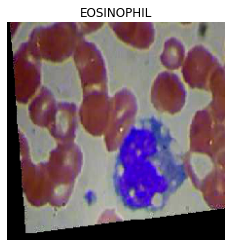

In [40]:
# Should not be strangely colored 
for x, y in test_gen_:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.axis(False)
  plt.show();
  break

In [41]:
# Create generators 

train_generator = train_gen.flow_from_directory(
    train_dir, 
    target_size=IMAGE_SIZE, 
    shuffle=True, 
    batch_size=BATCH_SIZE,
    class_mode='sparse' # int labels
)

test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    shuffle=False, # Don't need to shuffle test data
    batch_size=BATCH_SIZE,
    class_mode='sparse' 
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [112]:
# If wanted to add callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os 
from pathlib import Path

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.005,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_delta=0.02)

if not os.path.exists(Path("checkpoints")):
  os.mkdir(Path("checkpoints"))

checkpoint_dir = "checkpoints/inception_v4_model_3.ckpt"

checkpoint_callback = ModelCheckpoint(checkpoint_dir, monitor='val_accuracy', 
                                      save_best_only=True,
                                      save_weights_only=True)

In [115]:
%timeit
# Train the model 
inception_v4_history_0 = inception_v4_model.fit(
                          train_generator,
                          validation_data=test_generator, 
                          epochs=EPOCHS, 
                          steps_per_epoch=len(train_files) // BATCH_SIZE, 
                          validation_steps=len(test_files) // BATCH_SIZE, 
                          callbacks=[early_stopping, reduce_lr, checkpoint_callback]
    )

Epoch 1/30
311/311 [==============================] - 206s 505ms/step - loss: 5.5994 - accuracy: 0.6995 - val_loss: 5.5123 - val_accuracy: 0.2439 - lr: 1.0000e-04
Epoch 2/30
311/311 [==============================] - 156s 500ms/step - loss: 3.3033 - accuracy: 0.8893 - val_loss: 3.4097 - val_accuracy: 0.6985 - lr: 1.0000e-04
Epoch 3/30
311/311 [==============================] - 155s 498ms/step - loss: 2.1107 - accuracy: 0.9230 - val_loss: 2.2125 - val_accuracy: 0.7626 - lr: 1.0000e-04
Epoch 4/30
311/311 [==============================] - 158s 507ms/step - loss: 1.4841 - accuracy: 0.9314 - val_loss: 1.5812 - val_accuracy: 0.8575 - lr: 1.0000e-04
Epoch 5/30
311/311 [==============================] - 152s 488ms/step - loss: 1.1229 - accuracy: 0.9416 - val_loss: 1.5719 - val_accuracy: 0.7950 - lr: 1.0000e-04
Epoch 6/30
311/311 [==============================] - 152s 488ms/step - loss: 0.9058 - accuracy: 0.9492 - val_loss: 1.2313 - val_accuracy: 0.8555 - lr: 1.0000e-04
Epoch 7/30
311/311 [==

In [116]:
# Evaluate the model on test data 
inception_v4_model.evaluate(test_generator)

78/78 [==============================] - 10s 131ms/step - loss: 0.5692 - accuracy: 0.8830


[0.5691589713096619, 0.8829915523529053]

In [63]:
# inception_v4_model.save_weights("/content/drive/MyDrive/inception_v4/inception_v4_weights.ckpt")

In [66]:
# inception_v4_model.save("/content/drive/MyDrive/inception_v4/inception_v4_model")

In [54]:
# from google.colab import runtime
# runtime.unassign()

In [118]:
# Load in weights from resnet model (previously saved)
resnet_model.load_weights("/content/drive/MyDrive/custom_resnet_bloodcell_images/checkpoints/model_0_checkpoint")
resnet_loss, resnet_acc = resnet_model.evaluate(test_generator)
resnet_loss, resnet_acc

78/78 [==============================] - 6s 62ms/step - loss: 0.3637 - accuracy: 0.8798


(0.3636918067932129, 0.879774808883667)

In [ ]:
# Load in weights from inception-V4 model
# loaded_inception_v4_model = tf.keras.models.load_model("")
# inception_v4_loss, inception_v4_acc = loaded_inception_v4_model.evaluate(test_generator)
# inception_v4_loss, inception_v4_acc

In [117]:
# load in best weights from checkpoint callback
inception_v4_model.load_weights("/content/drive/MyDrive/inception_v4/checkpoints_model_3/inception_v4_model_3.ckpt")
inception_v4_model.evaluate(test_generator)

78/78 [==============================] - 10s 130ms/step - loss: 0.5692 - accuracy: 0.8830


[0.5691589713096619, 0.8829915523529053]

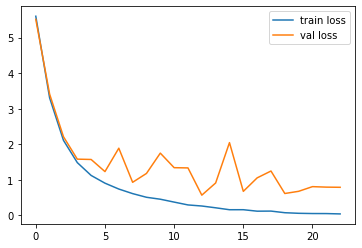

In [119]:
# Plot the losses of inception-v4 model
plt.plot(inception_v4_history_0.history['loss'], label='train loss')
plt.plot(inception_v4_history_0.history['val_loss'], label='val loss')
plt.legend()

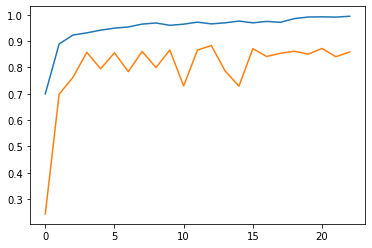

In [120]:
# Plot the accuracies resnet model and inception-v4 model
plt.plot(inception_v4_history_0.history['accuracy'], label='train acc')
plt.plot(inception_v4_history_0.history['val_accuracy'], label='val acc')

## Confusion matrices

In [ ]:
def get_confusion_matrix(data_path, N):
  print("Generating confusion matrix", N)
  # Empty lists for targets and predictions
  predictions = []
  targets = []
  i = 0 # counter 
  for x, y in test_gen.flow_from_directory(data_path, 
                                          target_size=IMAGE_SIZE, 
                                          shuffle=False,
                                           verbose=0):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1) # predicted label
    y = np.argmax(y, axis=1) # ground truth label 
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))

    if len(targets) >= N:
      break 
    
    cm = confusion_matrix(targets, predictions) 
    return cm

In [ ]:
cm = get_confusion_matrix(train_dir, len(train_files))  
print(cm)

In [ ]:
valid_cm = get_confusion_matrix(test_dir, len(test_files))
print(valid_cm)

In [ ]:
import itertools  
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  
  if normalize: 
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  else: 
    print('Non-normalized confusion matrix')

  print(cm)

  # Set up figure
  plt.figure(figsize=(25, 25))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i,j], fmt),
             horizontalalignment='center',
             color='white' if cm[i,j] > threshold else 'black')
    
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [ ]:
train_cm = plot_confusion_matrix(cm, classes=labels)
print(train_cm)

In [ ]:
val_cm = plot_confusion_matrix(valid_cm, classes=labels)
print(val_cm)